In [1]:
import torch
import torch.nn as nn

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

# getting process data from prepared dataset function earlier defined in data_utils file

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")


Train shape: (21708, 10, 6), Test shape: (5427, 10, 6)
Train targets shape: (21708, 6, 5), Test targets shape: (5427, 6, 5)
Train IDs shape: (21708,), Test IDs shape: (5427,)


## Process data

In [3]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

In [4]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

## Model Train

In [6]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [7]:
# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

Epoch 1/20 - Train Loss: 0.0169
Epoch 2/20 - Train Loss: 0.0099
Epoch 3/20 - Train Loss: 0.0093
Epoch 4/20 - Train Loss: 0.0085
Epoch 5/20 - Train Loss: 0.0080
Epoch 6/20 - Train Loss: 0.0078
Epoch 7/20 - Train Loss: 0.0072
Epoch 8/20 - Train Loss: 0.0070
Epoch 9/20 - Train Loss: 0.0069
Epoch 10/20 - Train Loss: 0.0069
Epoch 11/20 - Train Loss: 0.0067
Epoch 12/20 - Train Loss: 0.0068
Epoch 13/20 - Train Loss: 0.0067
Epoch 14/20 - Train Loss: 0.0068
Epoch 15/20 - Train Loss: 0.0068
Epoch 16/20 - Train Loss: 0.0066
Epoch 17/20 - Train Loss: 0.0068
Epoch 18/20 - Train Loss: 0.0065
Epoch 19/20 - Train Loss: 0.0066
Epoch 20/20 - Train Loss: 0.0065


In [8]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep_with_extraData.pth")
print("Model saved as seq2seq_lstm_multistep_with_extraData.pth")

Model saved as seq2seq_lstm_multistep_with_extraData.pth


## Evaluation

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace as Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ml.utils.data_utils import prepare_dataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM

In [10]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset_with_extraData.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

In [13]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep_with_extraData.pth", map_location=device))
model.eval()

Seq2SeqLSTM(
  (encoder): LSTM(6, 64, batch_first=True)
  (decoder): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [14]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

In [16]:

# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics MSE, RMSE, MAE, Rsquared, NRMSE
def evaluate(pred, actual, name):
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    nrmse = rmse / (actual.max() - actual.min())

    print(f"\n {name} Evaluation:")
    print(f"  - MSE   : {mse:.4f}")
    print(f"  - RMSE  : {rmse:.4f}")
    print(f"  - MAE   : {mae:.4f}")
    print(f"  - R²    : {r2:.4f}")
    print(f"  - NRMSE : {nrmse:.4f}")

# Loop through all target variables
print("\nEvaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


Evaluation Metrics for All 5 Targets:

 rnti_count Evaluation:
  - MSE   : 0.0097
  - RMSE  : 0.0983
  - MAE   : 0.0735
  - R²    : 0.4090
  - NRMSE : 0.1347

 rb_down Evaluation:
  - MSE   : 0.0197
  - RMSE  : 0.1402
  - MAE   : 0.0624
  - R²    : 0.4147
  - NRMSE : 0.1404

 rb_up Evaluation:
  - MSE   : 0.0118
  - RMSE  : 0.1086
  - MAE   : 0.0500
  - R²    : 0.6865
  - NRMSE : 0.1086

 down Evaluation:
  - MSE   : 0.0135
  - RMSE  : 0.1161
  - MAE   : 0.0677
  - R²    : 0.0340
  - NRMSE : 0.1161

 up Evaluation:
  - MSE   : 0.0325
  - RMSE  : 0.1804
  - MAE   : 0.0754
  - R²    : -0.5229
  - NRMSE : 0.1804


## Visualization

In [17]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


Forecast plots for rb_down


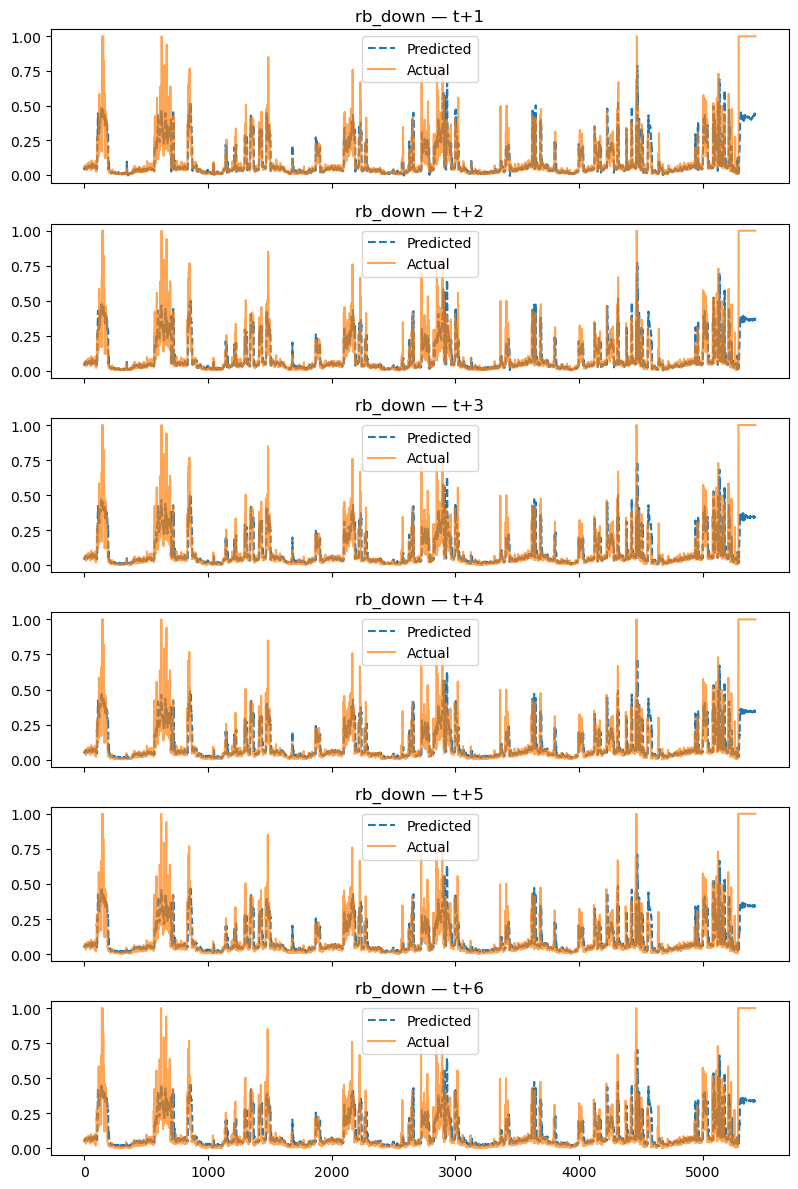

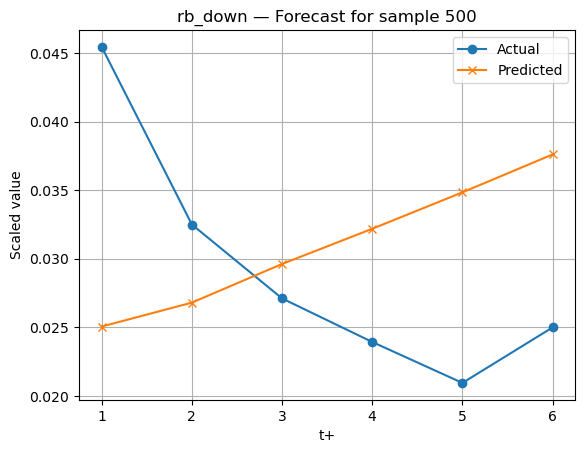


Forecast plots for down


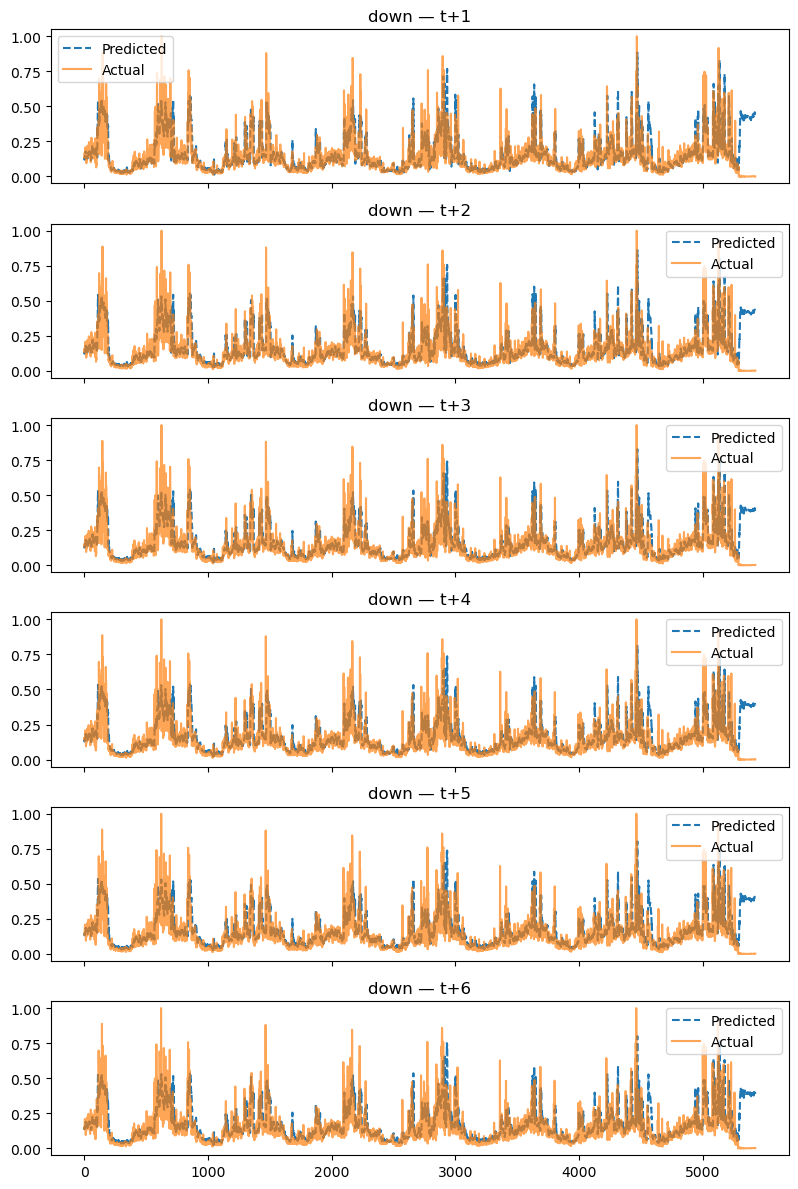

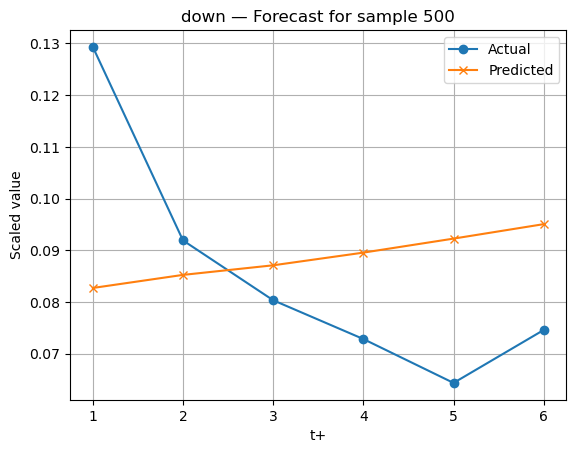

In [18]:
# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\nForecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)